# Home Depot Product Search Relevance 

# 1. Background

In this project, we are given a dataset that contains a number of products and real customer search terms from Home Depot's website. The challenge is to predict a relevance score for the provided combinations of search terms and products. To create the ground truth labels, Home Depot has crowdsourced the search/product pairs to multiple human raters. The relevance is a number between 1 (not relevant) to 3 (highly relevant).

We are provided with the following information:

    id - a unique Id field which represents a (search_term, product_uid) pair
    product_uid - an id for the products
    product_title - the product title
    product_description - the text description of the product (may contain HTML content)
    search_term - the search query
    name - an attribute name
    value - the attribute's value
    relevance - the average of the relevance ratings for a given id

Our task is to build up a regression model, and for each id in the test set, it should predict a relevance, which is a real number in [1,3].

# 2. Data Explore

First of all, we want to read data from HDFS and save them to dataframes.

In [5]:
#To succesfully run this script, you need to install nltk package.
import numpy as np
import pandas as pd
#import pysaprk
from pyspark import SparkContext
from pyspark import SQLContext

In [6]:
import pydoop
import pydoop.hdfs as hd
with hd.open("final/train.csv") as f:
    df_train =  pd.read_csv(f, encoding="ISO-8859-1")

In [7]:
with hd.open("final/test.csv") as f:
    df_test =  pd.read_csv(f, encoding="ISO-8859-1")
with hd.open("final/attributes.csv") as f:
    attr =  pd.read_csv(f)
with hd.open("final/product_descriptions.csv") as f:
    desc =  pd.read_csv(f, encoding="ISO-8859-1")

In [8]:
#read data
#df_train = pd.read_csv('./train.csv',encoding="ISO-8859-1")
#df_test = pd.read_csv('./test.csv',encoding="ISO-8859-1")
#attr = pd.read_csv("./attributes.csv")
#desc = pd.read_csv('./product_descriptions.csv', encoding="ISO-8859-1")

We can explore some basic information of train and test set.

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 5 columns):
id               74067 non-null int64
product_uid      74067 non-null int64
product_title    74067 non-null object
search_term      74067 non-null object
relevance        74067 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ MB


In [10]:
len(df_train['product_uid'].unique())

54667

In [11]:
len(df_test['product_uid'].unique())

97460

There are 54667 samples in the training dataset, and 97460 samples in test set. Based on number of products in training set and test set, there are around twice more numbers of products in test set than training set, which means the features(word) of about half instances in test set have never showed up in training set. This could be a big challenge for prediction on test set, as there could be many features the model could not catch during the training process. 

I also explored the distribution of relevance in training set, and ploted it as histogram.

In [12]:
df_train["relevance"].describe()

count    74067.000000
mean         2.381634
std          0.533984
min          1.000000
25%          2.000000
50%          2.330000
75%          3.000000
max          3.000000
Name: relevance, dtype: float64

In [13]:
%matplotlib inline 
import matplotlib.pyplot as plt

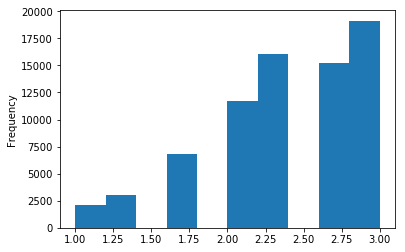

In [14]:
df_train["relevance"].plot.hist()

Obviously, the relevance is highly skewed in training data, as most of the score were from 2.00 to 3.00. While as the frequency of each bin is high, I think this should not be a very big problem for regression. So I keep all the data.

Then training set and test set were combined together for further pre-processing.

In [15]:
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

As different product has different numbers of attributes in attribute file, I want to combine them together and mapped it back based on product_uid, so it can be treated as a new text feature.

In [16]:
#join values of all names of one product
def join_values(attribute):
    #name = attribute["name"]
    values = attribute["value"]
    values_str= [str(i) for i in values.tolist()]
    result= " ".join(values_str)
    return result
    
newAttr= attr.groupby(["product_uid"]).apply(join_values)

In [17]:
attr = newAttr.reset_index(name="product_attributes")

In [18]:
attr

,product_uid,product_attributes
0,100001.0,Versatile connector for various 90° connection...
1,100002.0,"Brush,Roller,Spray 6.63 in 7.76 in 6.63 in Rev..."
2,100003.0,Yes Slightly narrower for tighter spaces Desig...
3,100004.0,8.56 Positive power tolerance (0 to +5-Watt) A...
4,100005.0,Combo Tub and Shower No Includes the trim kit ...
5,100006.0,Over the Range Microwave 18.5 in 17.13 in 29.9...
6,100007.0,Ni-Cad .Built-In LED Advanced LED technology i...
7,100008.0,.375 in 1.5 in .375 in For metal to metal fast...
8,100009.0,Door & Window Made of primed MDF Can be painte...
9,100010.0,No Can be used with all valley View lawn edgin...


In [19]:
#two new features, product description and attributes, are merged to dataframe
df_all = pd.merge(df_all, desc, how='left', on='product_uid')
df_all = pd.merge(df_all, attr, how="left", on="product_uid")


In [20]:
df_all.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 240760 entries, 0 to 240759
Data columns (total 7 columns):
id                     240760 non-null int64
product_title          240760 non-null object
product_uid            240760 non-null int64
relevance              74067 non-null float64
search_term            240760 non-null object
product_description    240760 non-null object
product_attributes     194935 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 14.7+ MB



Now, we have dataset with 5 features: <br>
    1. product_uid
    2. search_term
    3. product_title
    4. product_description
    5. product_attributes
    
And the target to be predicted is: <br>
    1. Relevance


# 3. Pre-processing

### 3.1 Fill in Missing values

In [21]:
#fill in the missing values in product_attributes
df_all["product_attributes"] = df_all["product_attributes"].fillna("")

In [22]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240760 entries, 0 to 240759
Data columns (total 7 columns):
id                     240760 non-null int64
product_title          240760 non-null object
product_uid            240760 non-null int64
relevance              74067 non-null float64
search_term            240760 non-null object
product_description    240760 non-null object
product_attributes     240760 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 14.7+ MB


### 3.2 Text Cleaning

The following steps were performed for text cleaning:<br> 
    1. Remove meaning symbols and synonyms substitution 
        Symbols such as "(", ")","," were removed as they do not bring information for search. 
        Words like "one", "two" were mapped back to corresponding numbers "1", "2", etc.
    2. Word lemmatization
        Lemmatization was performed to group together the inflected forms of a word so they can be analysed as a
        single item, identified by the word's lemma, or dictionary form. So words with the same lemma could be 
        grouped and analyzed together, which is helpful in similar search detection.
        
        Stemmer had also been tried here, while as it does not deal with different inflectional forms of a lemma,
        lemmatization should be more powerful. 
    3. Remove stop words
        Stop words are meaningless in semantics, and it is useless in out relevance analysis, so they were removed.

In [23]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [25]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()


In [26]:
#text cleaning for "product_title", "product_description", and "search_term"
def pre_word(line):
    line = line.lower()
    line = line.replace("  "," ")
    line = line.replace(",","") #transfer format like 10,000 to 10000
    line = line.replace("one","1")
    line = line.replace("two","2")
    line = line.replace("three","3")
    line = line.replace("four","4")
    line = line.replace("five","5")
    line = line.replace("six","6")
    line = line.replace("seven","7")
    line = line.replace("eight","8")
    line = line.replace("nine","9")
    line = line.replace("zero","0")
    line = line.replace("(","")
    line = line.replace(")","")
    
    words = line.split(" ")
    newWords=[]
    for word in words:
        word2 = lmtzr.lemmatize(word)
        if word2 not in stop:
            newWords.append(word2)
        #newWords.append(stemmer.stem(word))
    return " ".join(newWords)

In [27]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /home/jingzhip/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
#"product_attributes" need to be decoded with utf-8 and ignore unnormal values, so a new stem_word function was used
def pre_word2(line):
    line = line.lower()
    line = line.replace("  "," ")
    line = line.replace(",","") #transfer format like 10,000 to 10000
    line = line.replace("one","1")
    line = line.replace("two","2")
    line = line.replace("three","3")
    line = line.replace("four","4")
    line = line.replace("five","5")
    line = line.replace("six","6")
    line = line.replace("seven","7")
    line = line.replace("eight","8")
    line = line.replace("nine","9")
    line = line.replace("zero","0")
    line = line.replace("(","")
    line = line.replace(")","")


    words = line.split(" ")
    newWords=[]
    for word in words:
        word2 = lmtzr.lemmatize(word.decode('utf-8','ignore'))
        if word2 not in stop:
            newWords.append(word2)
    return " ".join(newWords)

In [42]:
df_all["product_title"] = df_all["product_title"].apply(pre_word)

In [43]:
df_all["product_description"] = df_all["product_description"].apply(pre_word)

In [44]:
df_all["search_term"] = df_all["search_term"].apply(pre_word)

In [45]:
df_all["product_attributes"] = df_all["product_attributes"].apply(pre_word2)

# 4. Feature Engineering

Based on the product exploration of training and test set, I don't think word2vec or one-hot vector is a good choice for this dataset. One reason is that there are many new features haven't showed up in training set, so the feature space is incomplete, which brings unaviodable error; the other reason is, as the dataset is very large, there could be a huge number of features if we use word2vec, which significant slows the process of model building.

Intuitively, the relevance is most related to the similarity between search term and product itself, so creating features that describe the similarity between search term and the product should be helpful. 

I used two different ways could be used to describe the similarity between search term and profuct information. 

### 4.1 First Strategy

The first strategy is intuitive. I created number of common words as features, which is the number of the same word that shows up in both search term and product information. The more common words they shared, the more relevent they should be. A meaningful feature would be the ratio of words that shared between search query and other text attributes of the product.

In [46]:
#return number of common words in c1 and c2
def common_words(c1, c2):
    result=[]
    for term, title in zip(c1, c2):
        term_list = term.split(" ")
        title_list = title.split(" ")
        result.append(sum(int(i in title_list) for i in term_list))
    return result

In [47]:
#calculate number of common words between search term and title, description, attributes 
search_term = df_all["search_term"]
product_title = df_all["product_title"]
product_description = df_all["product_description"]
product_attributes = df_all["product_attributes"]

In [49]:
common_search_title = common_words(search_term, product_title)
common_search_description = common_words(search_term, product_description)
common_search_attributes = common_words(search_term, product_attributes)

In [50]:
df_all["common_search_title"] = common_search_title
df_all["common_search_description"] = common_search_description
df_all["common_search_attributes"] = common_search_attributes

In [51]:
#length of search term
df_all["len_search_term"] = [ len(term.split(" ")) for term in search_term]

In [53]:
#the ratio of words in search term that hit product title
df_all['ratio_search_title'] = df_all["common_search_title"] / df_all["len_search_term"]

In [54]:
#the ratio of words in search term that hit product discription
df_all['ratio_search_description'] = df_all["common_search_description"] / df_all["len_search_term"]

In [55]:
#the ratio of words in search term that hit product attributes
df_all['ratio_search_attri'] = df_all["common_search_attributes"] / df_all["len_search_term"]

### 4.2 Second Strategy
The second strategy is to describe the similarity between search term and product information with cosine similarity. We need to first transform the text to tfidf vectors and then calculate cosine similarity between the search term and each product information. 

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  

In [57]:
#return cosine similarity between search_term(c1) and title(c2)
def cal_cosine(c1, c2):
    result=[]
    for term, title in zip(c1, c2):
        corpus = [term, title]
        tfidf_vectorizer = TfidfVectorizer()
        tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
        cosine = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[0])
        result.append(cosine[0][0])
    return result

In [58]:
#calculate the cosine similarity between search term and product title 
df_all['cos_search_title'] = cal_cosine(df_all["search_term"], df_all["product_title"])
#calculate the cosine similarity between search term and product description
df_all['cos_search_description'] = cal_cosine(df_all["search_term"], df_all["product_description"])

In [59]:
df_all

,id,product_title,product_uid,relevance,search_term,product_description,product_attributes,common_search_title,common_search_description,common_search_attributes,len_search_term,ratio_search_title,ratio_search_description,ratio_search_attri,cos_search_title,cos_search_description
0,2,simpson strong-tie 12-gauge angle,100001,3.00,angle bracket,angle make joint stronger also provide consist...,versatile connector various 90° connection hom...,1,1,0,2,0.500000,0.500000,0.000000,0.175786,0.074682
1,3,simpson strong-tie 12-gauge angle,100001,2.50,l bracket,angle make joint stronger also provide consist...,versatile connector various 90° connection hom...,0,0,0,2,0.000000,0.000000,0.000000,0.000000,0.000000
2,9,behr premium textured deckover 1-gal. #sc-141 ...,100002,3.00,deck,behr premium textured deckover innovative soli...,brushrollerspray 6.63 7.76 6.63 revives wood c...,0,1,1,1,0.000000,1.000000,1.000000,0.000000,0.164410
3,16,delta vero 1-handle shower faucet trim kit chr...,100005,2.33,rain shower head,update bathroom delta vero single-handle showe...,combo tub shower includes trim kit rough-in ki...,1,1,2,3,0.333333,0.333333,0.666667,0.103716,0.034786
4,17,delta vero 1-handle shower faucet trim kit chr...,100005,2.67,shower faucet,update bathroom delta vero single-handle showe...,combo tub shower includes trim kit rough-in ki...,2,2,2,2,1.000000,1.000000,1.000000,0.335176,0.109780
5,18,whirlpool 1.9 cu. ft. range convection microwa...,100006,3.00,convection otr,achieving delicious result almost effortless w...,range microwave 18.5 17.13 29.94 spacious 1.9 ...,1,1,1,2,0.500000,0.500000,0.500000,0.133785,0.056757
6,20,whirlpool 1.9 cu. ft. range convection microwa...,100006,2.67,microwave stove,achieving delicious result almost effortless w...,range microwave 18.5 17.13 29.94 spacious 1.9 ...,1,1,1,2,0.500000,0.500000,0.500000,0.133785,0.056757
7,21,whirlpool 1.9 cu. ft. range convection microwa...,100006,3.00,microwave,achieving delicious result almost effortless w...,range microwave 18.5 17.13 29.94 spacious 1.9 ...,1,1,1,1,1.000000,1.000000,1.000000,0.230768,0.097901
8,23,lithonia lighting quantum 2-light black led em...,100007,2.67,emergency light,quantum adjustable 2-light led black emergency...,ni-cad .built-in led advanced led technology d...,1,2,2,2,0.500000,1.000000,1.000000,0.355477,0.178532
9,27,house fara 3/4 in. x 3 in. x 8 ft. mdf fluted ...,100009,3.00,mdf 3/4,get house fara 3/4 in. x 3 in. x 8 ft. mdf flu...,door & window made primed mdf painted match de...,2,2,1,2,1.000000,1.000000,0.500000,0.230768,0.085343


Now all the text features are transfromed to numerical fetaures, and text features could be dropped.

In [60]:
#drop text features
df = df_all.drop([ "product_title", "search_term", "product_description", "product_attributes"], axis=1)

In [61]:
df = df.drop(["common_search_title", "common_search_description","common_search_attributes"], axis=1)

In [74]:
df.to_csv('df.csv', columns = ["id", "relevance","len_search_term","ratio_search_title","ratio_search_description","ratio_search_attri","cos_search_title","cos_search_description"], index = False)

# 5. Model Building

In this part, Random Forest regression model were built up on Spark to fit the dataset. 

### 5.1. data preparation
First, the dataset should be transfered to spark platform and new dataframes should be created.

In [62]:
#split train and test set
train = df[:len(df_train)]
#train

In [63]:
test = df[len(df_train):]
test = test.drop(["relevance"], axis=1)

In [64]:
import pyspark
from pyspark import SparkContext
from pyspark import SQLContext

from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [65]:
sc = SparkContext()
sqlContext = SQLContext(sc)

In [66]:
df_train_spark = sqlContext.createDataFrame(train)
df_train_spark.printSchema()

root
 |-- id: long (nullable = true)
 |-- product_uid: long (nullable = true)
 |-- relevance: double (nullable = true)
 |-- len_search_term: long (nullable = true)
 |-- ratio_search_title: double (nullable = true)
 |-- ratio_search_description: double (nullable = true)
 |-- ratio_search_attri: double (nullable = true)
 |-- cos_search_title: double (nullable = true)
 |-- cos_search_description: double (nullable = true)



In [67]:
df_test_spark = sqlContext.createDataFrame(test) 
df_test_spark.printSchema()

root
 |-- id: long (nullable = true)
 |-- product_uid: long (nullable = true)
 |-- len_search_term: long (nullable = true)
 |-- ratio_search_title: double (nullable = true)
 |-- ratio_search_description: double (nullable = true)
 |-- ratio_search_attri: double (nullable = true)
 |-- cos_search_title: double (nullable = true)
 |-- cos_search_description: double (nullable = true)



### 5.2. Random Forest Regressor Building
Random forest regression is a good choice, as it is an ensemble method, in which the final prediction is based on the mean prediction of each tree. Overfitting could be avoided in this way. So I choose random forest regressor.

First, a baseline model was built up. In order to evaluate the model performance during the training process, 20% of training data were randomly extracted from training set and performed as validation set, which performed as test data during training process. Default paramteres were used for baseline builder, and we explicitly design the number of trees as 50.

The features I used are:
    1. product_uid
    2. len_search_term
    3. ratio_search_title
    4. ratio_search_description
    5. ratio_search_attri
    6. cos_search_title
    7. cos_search_description

In [68]:
from pyspark.ml.feature import VectorAssembler

In [75]:
# Split the data into training and test sets (20% held out for testing)
(train, validation) = df_train_spark.randomSplit([0.8, 0.2])

In [76]:
#construct a feature vector as assembler
assembler = VectorAssembler(
    inputCols=[x for x in train.columns if x not in ['id', 'relevance']],
    outputCol='features')
#assembler.transform(df_train_spark)
assembler.transform(train)
assembler.transform(validation)
assembler.transform(df_test_spark)

DataFrame[id: bigint, product_uid: bigint, len_search_term: bigint, ratio_search_title: double, ratio_search_description: double, ratio_search_attri: double, cos_search_title: double, cos_search_description: double, features: vector]

In [71]:
# Train a RandomForest model.
rf_reg = RandomForestRegressor(featuresCol="features", labelCol="relevance", numTrees=50)

In [77]:
# Chain indexer and forest in a Pipeline
pipeline1 = Pipeline(stages=[assembler, rf_reg])

In [78]:
# Train model.  This also runs the indexer.
model1 = pipeline1.fit(train)

In [79]:
# Make predictions.
predictions1 = model1.transform(validation)

In order to evaluate the performance of baseline model, I choose Root Mean Squared Error(RMSE), which was used in Kaggle for performance test. 

In [80]:
# Select (prediction, true relevance) and compute test error
evaluator1 = RegressionEvaluator(
    labelCol="relevance", predictionCol="prediction", metricName="rmse")
rmse = evaluator1.evaluate(predictions1)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.483316


The baseline has 0.483 RMSE on validation set. Then prediction on test dataset was performed and the relevance score were output to a csv file for Kaggle test.

In [81]:
#predictionon test set
predictions1 = model1.transform(df_test_spark)

In [82]:
#write to csv
test_mat= predictions1.toPandas()
test_mat = test_mat.rename(columns={'prediction': 'relevance'})
test_mat.to_csv('pred.csv', columns = ["id", "relevance"], index = False)

The model with default parameters of random forest regressor gave a public score of 0.48849, a private score of 0.48796 on Kaggle. It is not a very good score on leaderborad, one of the reasons could be that there is no parameter optimization on regression model.

A histgram is helpful to explore the distribution of predictions on test set.

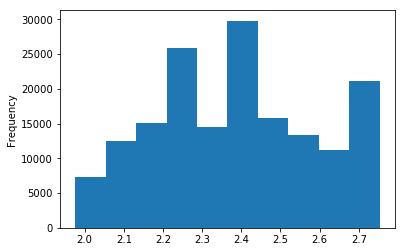

In [83]:
#plot histogram of relevance score
test_mat["prediction"].plot.hist()

Obviously, the distribution of predictions on test set is highly skewed, as all of the predictions are no smaller than 2.0. Suppose the training set and test set have the same distribution, then all the instances that have low relevance score will make strong contributions to RMSE. It also suggested that more optimization should be performed on current model.

# 6. Performance Optimization
There are two ways to improve the performance of regressor, one is feature engineering, designing more powerful features and droping noisy features; the other one is model optimization, including parameter optimization and cross-validation.

### 6.1 Feature Enginerring - Importance Analysis
Based on the baseline model, we can first see if there is any feature that have low weight, whcih could be considered as irrelavant and dropped.

Currently, we have the following features in regressor:
    1. product_uid
    2. len_search_term
    3. ratio_search_title
    4. ratio_search_description
    5. ratio_search_attri
    6. cos_search_title
    7. cos_search_description
    
The parameter 'featureImportances' shows the weight of each feature in the regressor.

In [91]:
#df_train_spark.printSchema()

root
 |-- id: long (nullable = true)
 |-- product_uid: long (nullable = true)
 |-- relevance: double (nullable = true)
 |-- len_search_term: long (nullable = true)
 |-- ratio_search_title: double (nullable = true)
 |-- ratio_search_description: double (nullable = true)
 |-- ratio_search_attri: double (nullable = true)
 |-- cos_search_title: double (nullable = true)
 |-- cos_search_description: double (nullable = true)



In [88]:
#print the weight of each feature
[stage.featureImportances for stage in model1.stages if hasattr(stage, "featureImportances")]

[SparseVector(7, {0: 0.09, 1: 0.0319, 2: 0.3691, 3: 0.1661, 4: 0.0103, 5: 0.2855, 6: 0.0472})]

Obviously, the features that are most important are:
    2. ratio_search_title, with highest weight of 0.3691
    5. cos_search_title, with weight of 0.2855
    3. ratio_search_description, with weight of 0.1661
    
These three features explained about 72% of the regressor. None of the other features has weight over 0.1, which suggest that they are not highly related to the relevance score. Intuitively, dropping those features could be helpful to decrease the noise in the regressor. So I tried to drop some features and build new regressors.

Intuitively, the product_uid shoudl not be relevant to the prediction. So I tried to throw 'product_uid' and calculated rmse on the new model.

In [92]:
#construct a feature vector as assembler
assembler2 = VectorAssembler(
    inputCols=[x for x in train.columns if x not in ['id','product_uid', 'relevance']],
    outputCol='features')
#assembler.transform(df_train_spark)
assembler2.transform(train)
assembler2.transform(validation)
assembler2.transform(df_test_spark)

# Train a RandomForest model.
rf_reg2 = RandomForestRegressor(featuresCol="features", labelCol="relevance", numTrees=50)

# Chain indexer and forest in a Pipeline
pipeline2 = Pipeline(stages=[assembler2, rf_reg2])

# Train model.  This also runs the indexer.
model2 = pipeline2.fit(train)

# Make predictions.
predictions2 = model2.transform(validation)

# Select (prediction, true relevance) and compute test error
evaluator2 = RegressionEvaluator(
    labelCol="relevance", predictionCol="prediction", metricName="rmse")
rmse2 = evaluator2.evaluate(predictions2)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse2)


Root Mean Squared Error (RMSE) on test data = 0.486874


In [93]:
[stage.featureImportances for stage in model2.stages if hasattr(stage, "featureImportances")]

[SparseVector(6, {0: 0.044, 1: 0.3246, 2: 0.203, 3: 0.0502, 4: 0.3222, 5: 0.056})]

Based on the above analysis, the new RMSE score is around 0.487, which is a bit higher than baseline of 0.483. This suggests that 'product_uid' is a useful feature in regressor. 

On the other hand, the three most important features are still ratio_search_title, cos_search_title, and ratio_search_description, in the new regressor they explained more than 80% of the weight. So I tried throwing all the other features, and only use these three features for regression.

In [94]:
#construct a feature vector as assembler
assembler3 = VectorAssembler(
    inputCols=[x for x in train.columns if x in ['ratio_search_title','ratio_search_description', 'cos_search_title']],
    outputCol='features')
#assembler.transform(df_train_spark)
assembler3.transform(train)
assembler3.transform(validation)
assembler3.transform(df_test_spark)

# Train a RandomForest model.
rf_reg3 = RandomForestRegressor(featuresCol="features", labelCol="relevance", numTrees=50)

# Chain indexer and forest in a Pipeline
pipeline3 = Pipeline(stages=[assembler3, rf_reg3])

# Train model.  This also runs the indexer.
model3 = pipeline3.fit(train)

# Make predictions.
predictions3 = model3.transform(validation)

# Select (prediction, true relevance) and compute test error
evaluator3 = RegressionEvaluator(
    labelCol="relevance", predictionCol="prediction", metricName="rmse")
rmse3 = evaluator3.evaluate(predictions3)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse3)

Root Mean Squared Error (RMSE) on test data = 0.489295


Unfortunately, RMSE score kept increasing as the number of features descresed. It suggests that although some features are not very important, they still contribute to the accuracy of regressor, and cannot be treated as noise. So I kept all the features and go to the next stage.

### 6.2 Parameter Optimization and Cross-Validation

ParamGridBuilder() and CrossValidator() are the functions for parameter optimization and cross-validation in pySpark.

I tried to tune the following parameters in random forest model:<br>
    1. numTrees: Number of trees to train. In baseline I used numTrees=50. If numTrees is too small, the ensemble
    method cannot show a good prediction ability, if it is too large, the model is more pruned to be overfitting.
    2. maxDepth: Maximum depth of the tree. It will decrease the prediction ability if it is too small, and will
    pruned to be overfitting if too large.
    3. subsamplingRate: Fraction of the training data used for learning each decision tree, in range (0, 1].
    
I tried two experiment in cross-validation, in the first experiment, I tuned numTrees and maxDepth, and in the second experiment, I added subsamplingRate. The reason I split it into two is, the optimal parameters in the first experiment could help to reduce the parameter space in the second experiment, otherwise the cross-validation will be too slow.

In [100]:
#cross-validation Pipeline
rf = RandomForestRegressor(featuresCol="features", labelCol="relevance")
pipeline_cv = Pipeline(stages=[assembler, rf])

In [96]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [101]:
#paramGridBuilder for parameter search
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50,100,200])\
    .addGrid(rf.maxDepth, [1,3,5])\
    .build()

In [102]:
#rmse for evalutor
evaluator1 = RegressionEvaluator(
    labelCol="relevance", predictionCol="prediction", metricName="rmse")

In [103]:
#cross-validation random forest regressor built up
crossval = CrossValidator(estimator=pipeline_cv,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator1,
                          numFolds=3)

In [104]:
## Train model. 
CV_model = crossval.fit(df_train_spark)

In [105]:
#The best model in cross-validation models
tree_model = CV_model.bestModel.stages[1]
#print tree_model

RandomForestRegressionModel (uid=rfr_9d64846791ab) with 100 trees


In [106]:
#print the best parameters of the best model
print 'Best Param (regParam): ', tree_model._java_obj.getNumTrees()
print 'Best Param (regParam): ', tree_model._java_obj.getMaxDepth()

Best Param (regParam):  100
Best Param (regParam):  5


In [107]:
#another cross-validation regressor, subsampling rate added
paramGrid2 = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50,100])\
    .addGrid(rf.maxDepth, [3,5])\
    .addGrid(rf.subsamplingRate, [0.5,0.7,0.9])\ 
    .build()
    
crossval2 = CrossValidator(estimator=pipeline_cv,
                          estimatorParamMaps=paramGrid2,
                          evaluator=evaluator1,
                          numFolds=3)
CV_model2 = crossval2.fit(df_train_spark)
tree_model2 = CV_model2.bestModel.stages[1]
print 'Best Param (regParam): ', tree_model2._java_obj.getNumTrees()
print 'Best Param (regParam): ', tree_model2._java_obj.getMaxDepth()
print 'Best Param (regParam): ', tree_model2._java_obj.getSubsamplingRate()

Best Param (regParam):  100
Best Param (regParam):  5
Best Param (regParam):  0.5


# 7. Kaggle Score
Based on the cross-validation result, the best model could be used for final predictions. And I used the predictions for Kaggle evaluation.

In [112]:
#Make predictions
finalPredictions = CV_model2.bestModel.transform(df_test_spark)

In [116]:
#save predictions to pred.csv
test_pred= finalPredictions.toPandas()
test_pred = test_pred.rename(columns={'prediction': 'relevance'})
test_pred.to_csv('pred.csv', columns = ["id", "relevance"], index = False)

Here are the Kaggle scores:

<img src="kaggle_score.png">

Based on the distribution of predictions, an obvious problem is that, the distribution is also highly skewed, like the training set predictions. It could be a error source for the regressor, and cause a large RMSE.

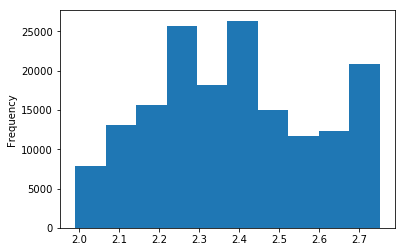

In [110]:
test_pred["prediction"].plot.hist()

# 8. Conclusion

In this project, I learnt how to deal with text features, and severl ways to convert the text features to numerical values, which should be very helpful for my understanding of NLP. I gained practical skills using spark machine learning library, and it is very useful for large dataset. I created meaningful features, and used ensemble methods to built up a regressor.

The issues I met the most come from the computation resources on aspen cluster. As it is a really huge dataset, it is easily to occupied many computational resources during pre-processing and model training, and I really came across so many times that kernel crushed just before the model is about to be finished, so I have to restart it and train from the begining, it is very frustrated and a waste of time. After too many failures, I learned to always save the mid point result as a file. After the kernel crushed, I can read the mid point result from hard disk, and it helps to save a lot of time.

The result of this project is meaningful, however, there are still some points I could try in the future. For example, word2vec and edit distance are the features that I did not used, but they could be helpful for performance. More powerful features could also be created, especially for the search term and product title, as there is evidence on feature importance showing that there should be strong relevance between them. And other models could also be tried, such as xgboost. And I think techniques to deal with imbalanced data, such as down-sampling, are also worth trying for our dataset.
